In [1]:
import sys
sys.path.append('..')

from models.cnn.trainer import Trainer

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
trainer = Trainer()

In [ ]:
trainer.train(2)

In [4]:
# trainer.load_model("./model_state.pt")

In [4]:
trainer.evaluate("test")

RMSE for t2m: 2.922577357009479; MAE for t2m: 2.313259467364046;
RMSE for sp: 5.036614898966658; MAE for sp: 4.010803671352146;
RMSE for tcc: 0.3659820240937233; MAE for tcc: 0.29493546619016076;
RMSE for u10: 2.89915892195621; MAE for u10: 2.279375548342127;
RMSE for v10: 1.8029109163027426; MAE for v10: 1.389097178298621;
RMSE for tp: 0.00031321285256841473; MAE for tp: 8.581334918252224e-05;


In [6]:
trainer.evaluate("val")

RMSE for t2m: 1.7199010992144435; MAE for t2m: 1.2956242564357001;
RMSE for sp: 1.6058434180958425; MAE for sp: 1.2086651795860583;
RMSE for tcc: 0.2864882132224856; MAE for tcc: 0.19461334342803469;
RMSE for u10: 1.3194578957003176; MAE for u10: 0.9767489859532124;
RMSE for v10: 1.3084604815870122; MAE for v10: 0.9633588356592744;
RMSE for tp: 0.00029559497975706773; MAE for tp: 8.042210990307226e-05;


In [9]:
trainer.evaluate("train")

RMSE for t2m: 1.6056668295087637; MAE for t2m: 1.2082205399936867;
RMSE for sp: 1.5577218743349266; MAE for sp: 1.1523502682255968;
RMSE for tcc: 0.2831834624643187; MAE for tcc: 0.18972778240979785;
RMSE for u10: 1.2559222658496183; MAE for u10: 0.9218666984553306;
RMSE for v10: 1.2492818163076784; MAE for v10: 0.9100379483323733;
RMSE for tp: 0.0003078040717901862; MAE for tp: 8.25371774694316e-05;


RMSE for t2m: 1.472989797592163; MAE for t2m: 1.1596883535385132;
RMSE for sp: 1.544997215270996; MAE for sp: 1.2230902910232544;
RMSE for tcc: 0.3108101189136505; MAE for tcc: 0.22717592120170593;
RMSE for u10: 1.632959246635437; MAE for u10: 1.1932868957519531;
RMSE for v10: 1.4714715480804443; MAE for v10: 1.1226258277893066;
RMSE for tp: 0.0004264787130523473; MAE for tp: 0.00015687990526203066;


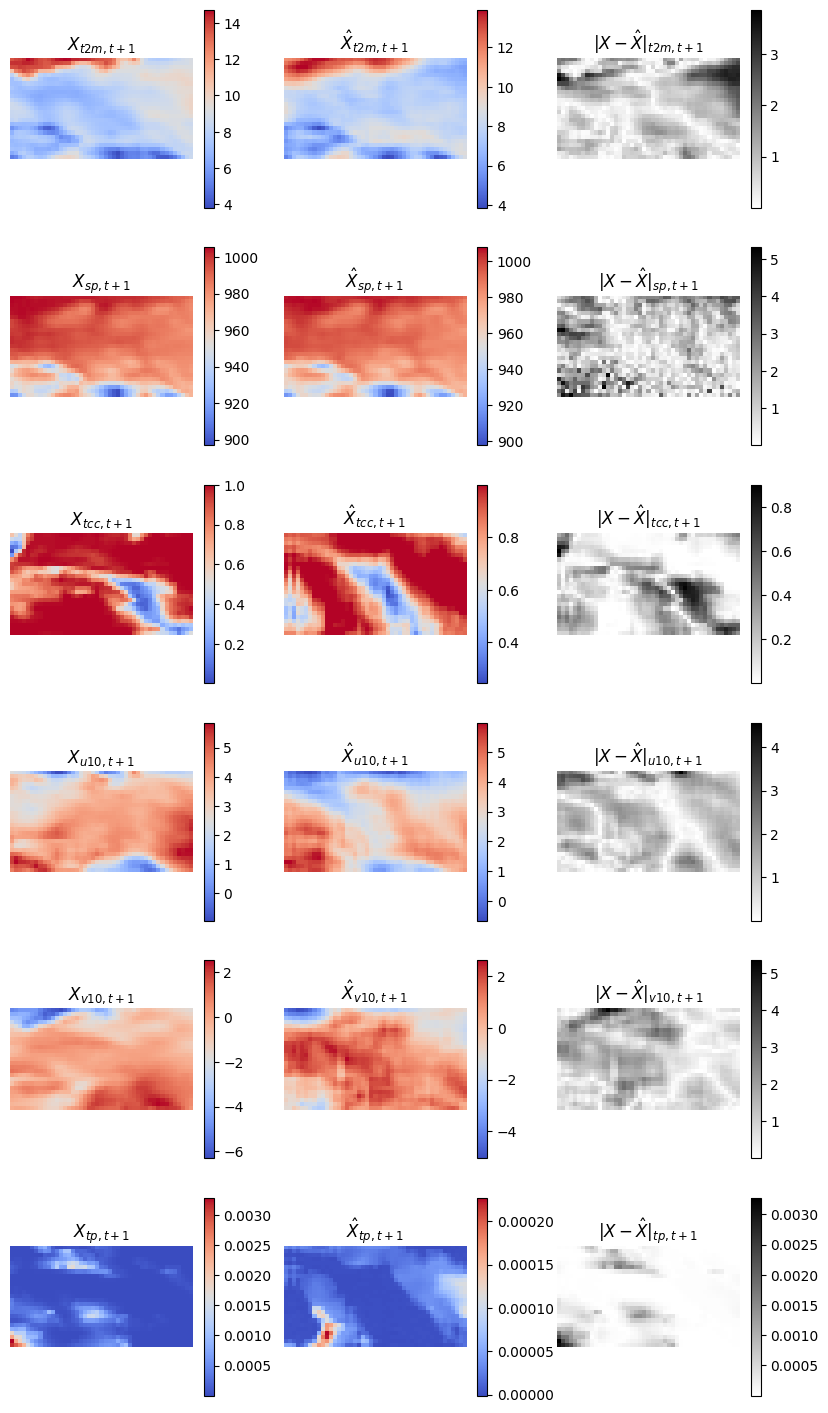

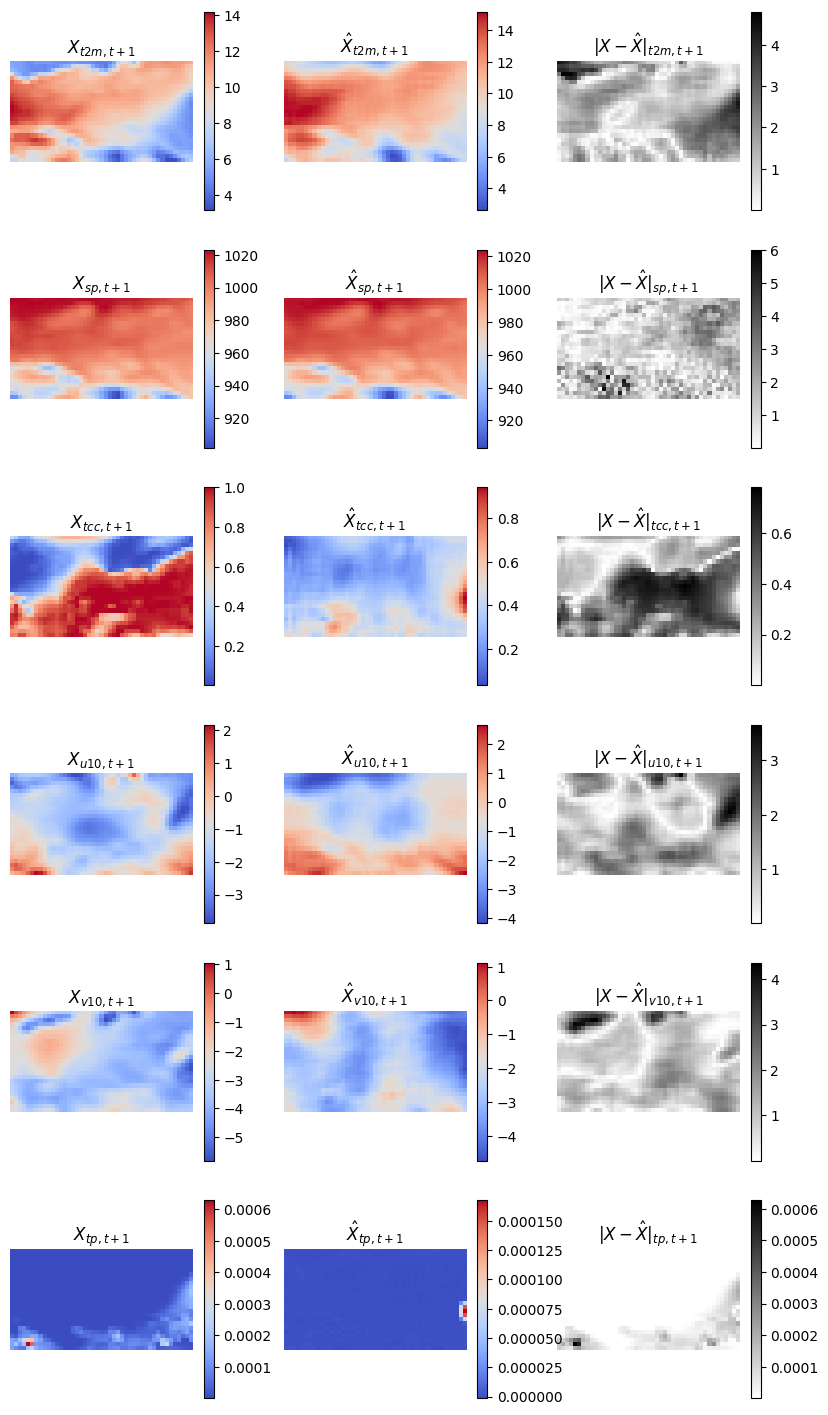

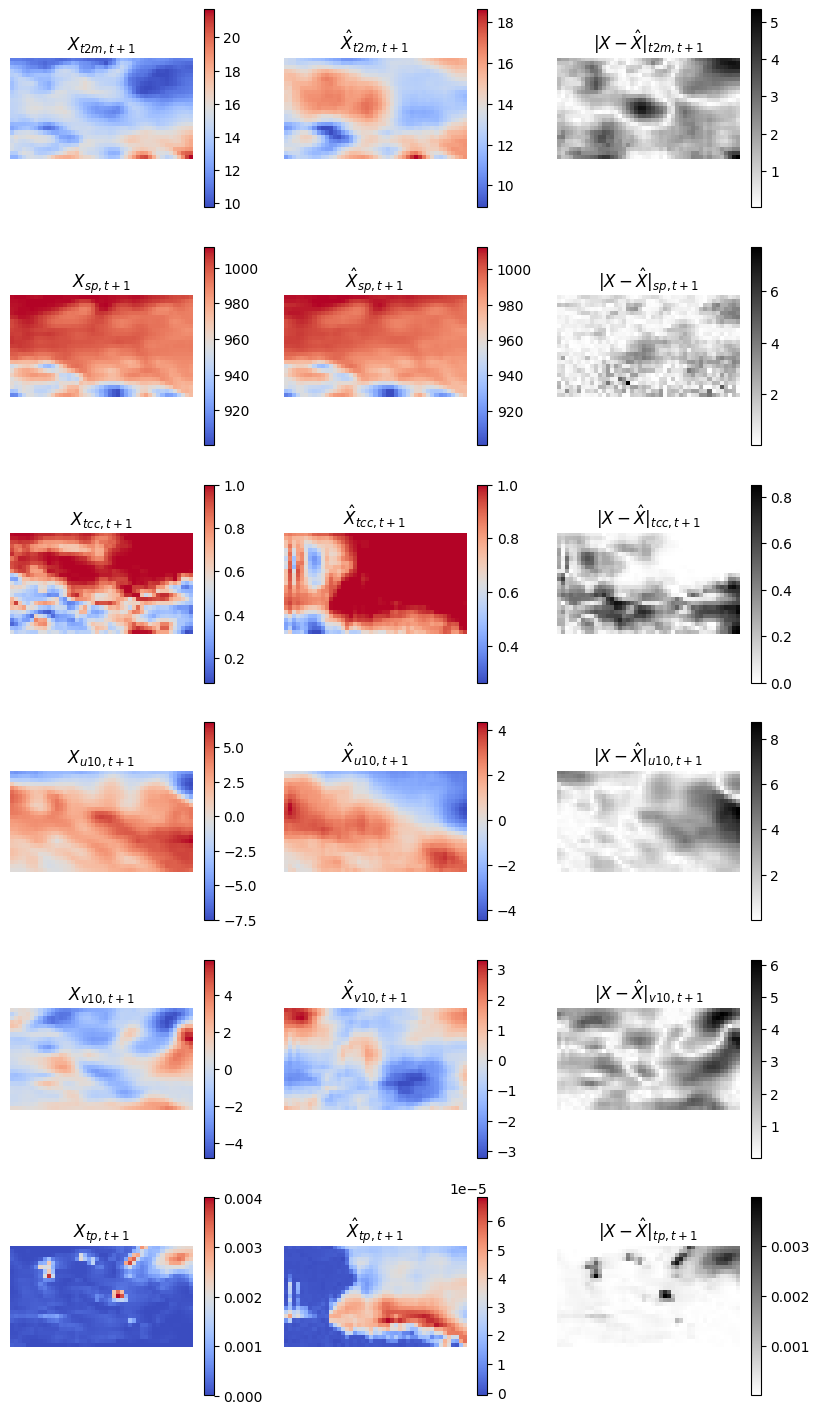

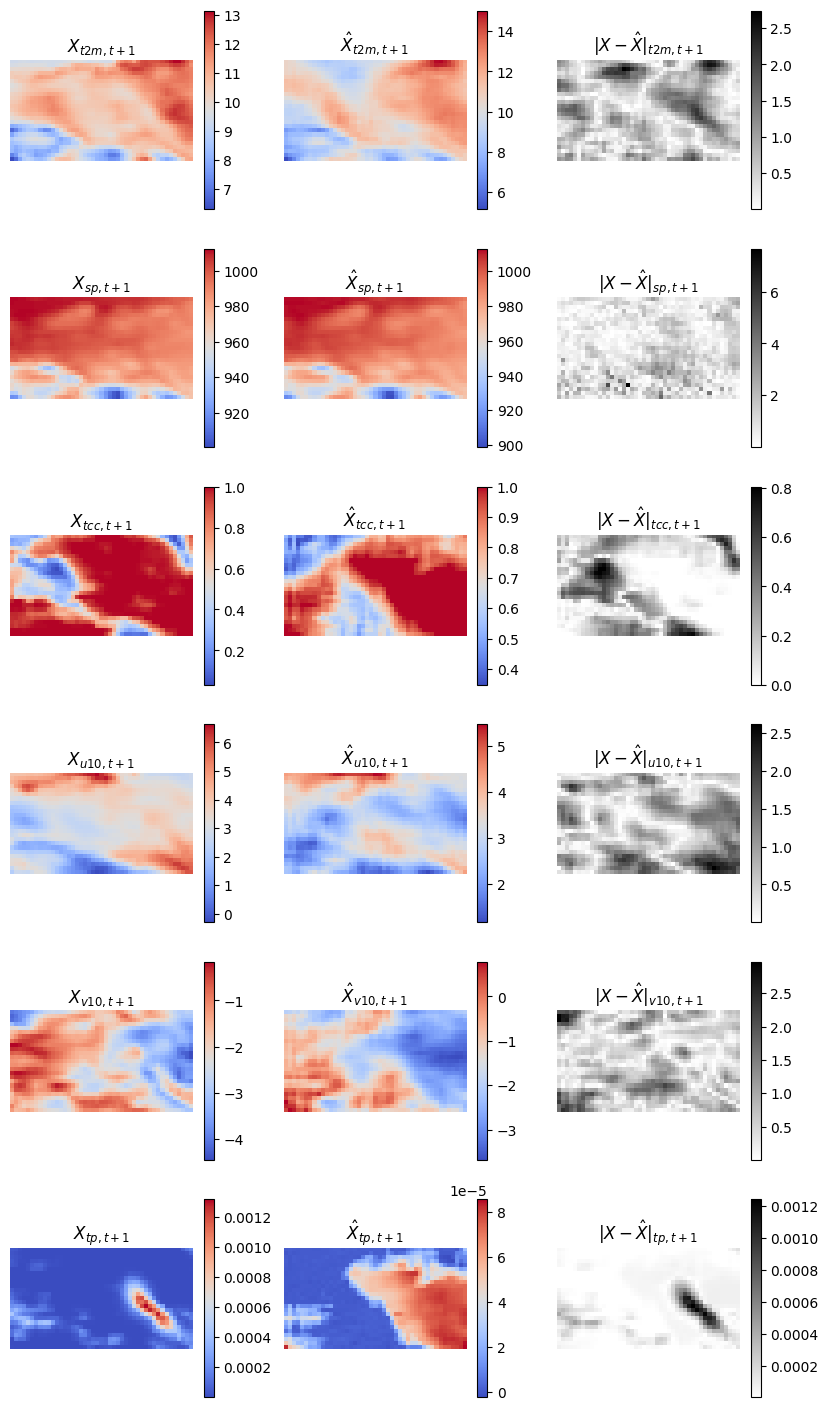

In [7]:
trainer.plot_predictions(data_type='test', pretty=False)

RMSE for t2m: 1.2540562152862549; MAE for t2m: 0.9799814224243164;
RMSE for sp: 2.8730762004852295; MAE for sp: 2.039942741394043;
RMSE for tcc: 0.2789990305900574; MAE for tcc: 0.19829446077346802;
RMSE for u10: 0.9681245684623718; MAE for u10: 0.7496526837348938;
RMSE for v10: 1.2976789474487305; MAE for v10: 0.9770455956459045;
RMSE for tp: 0.00011597834236454219; MAE for tp: 3.6967743653804064e-05;


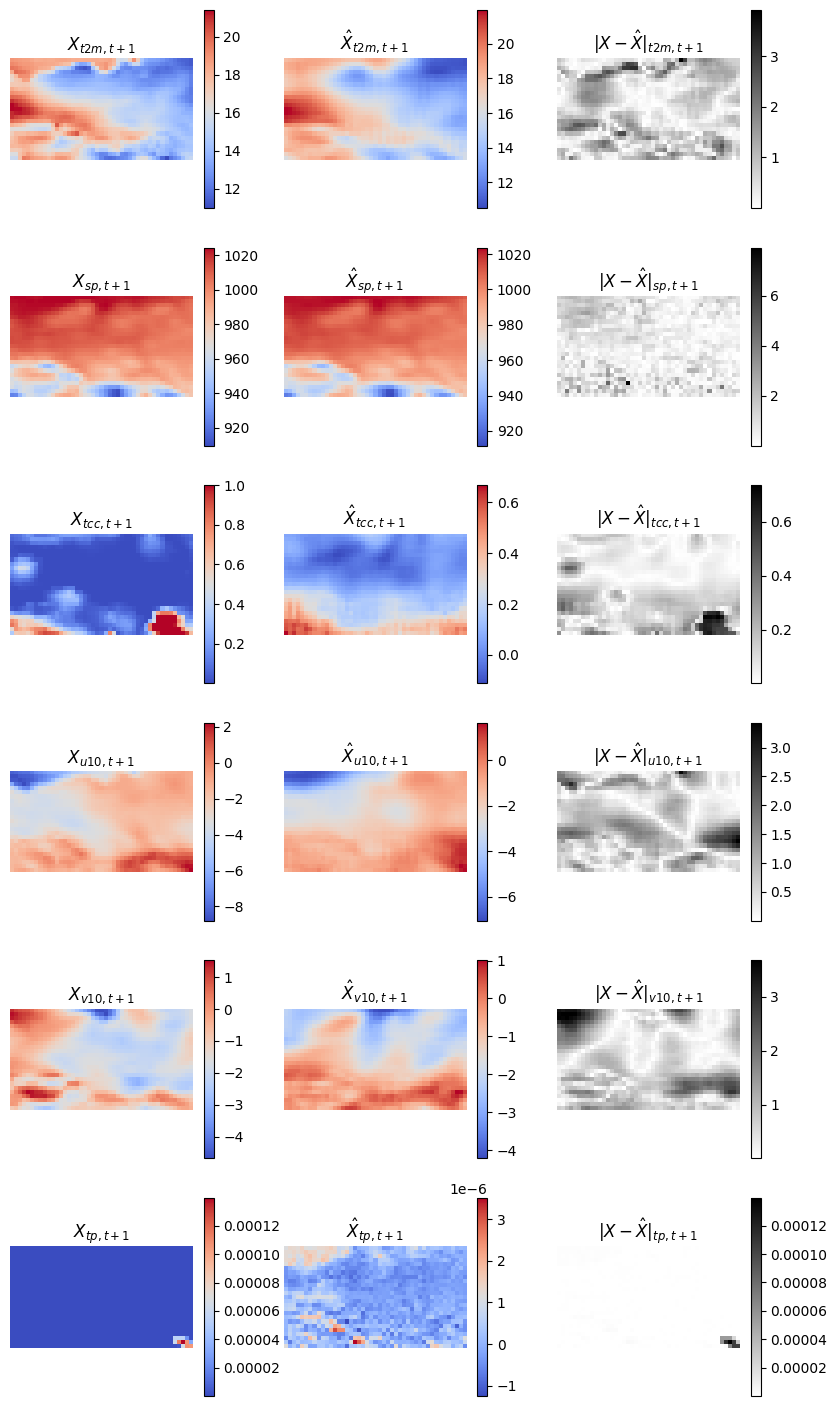

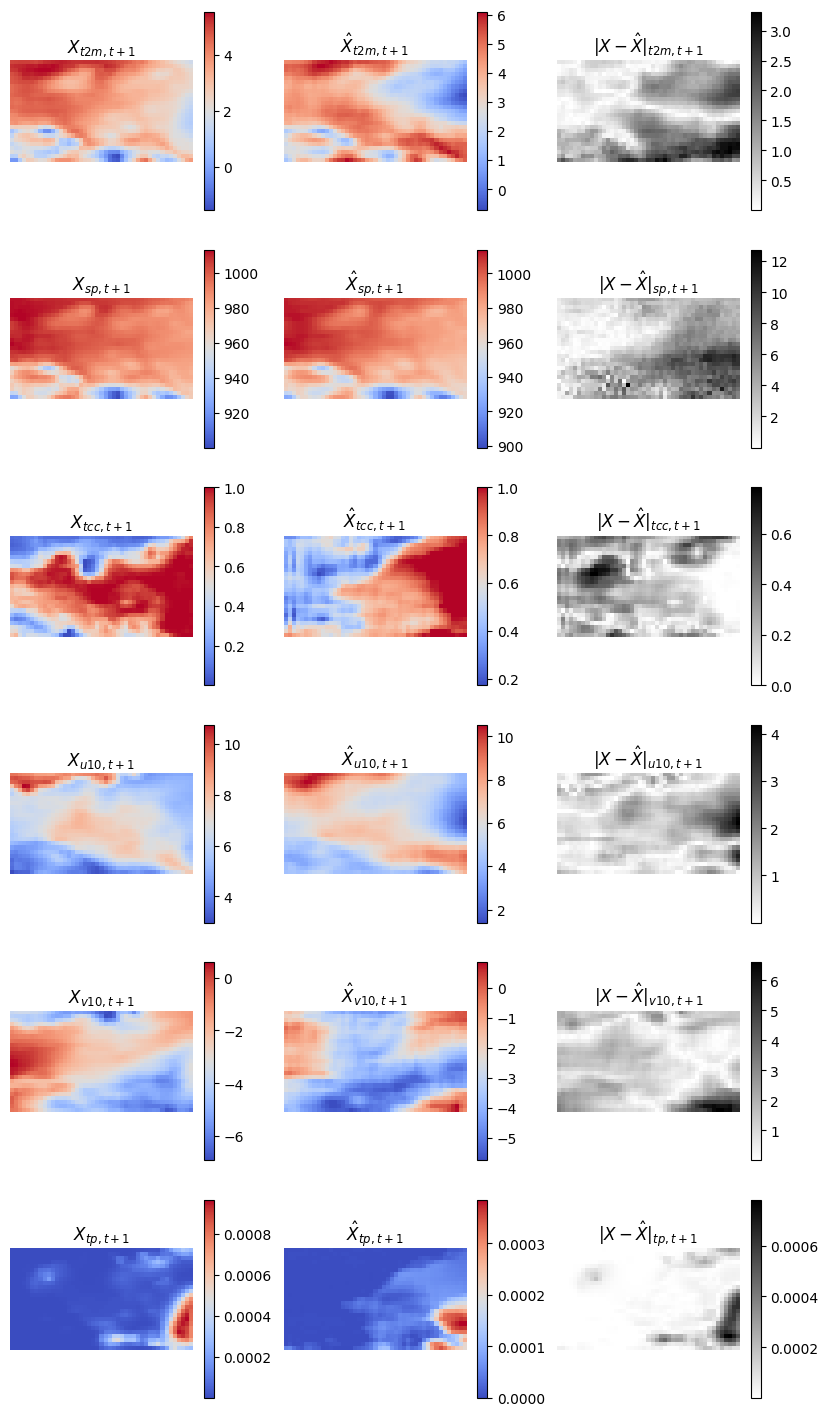

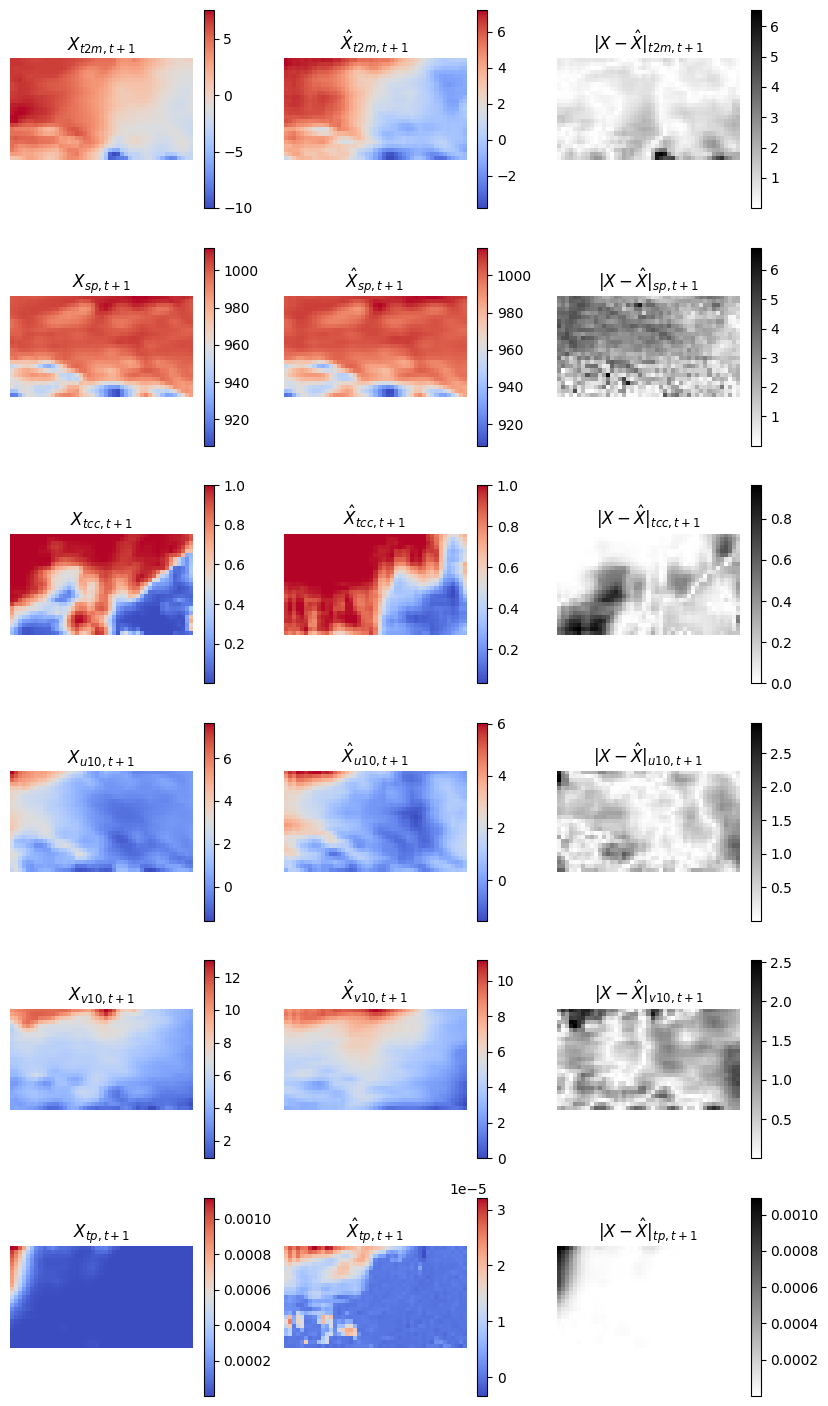

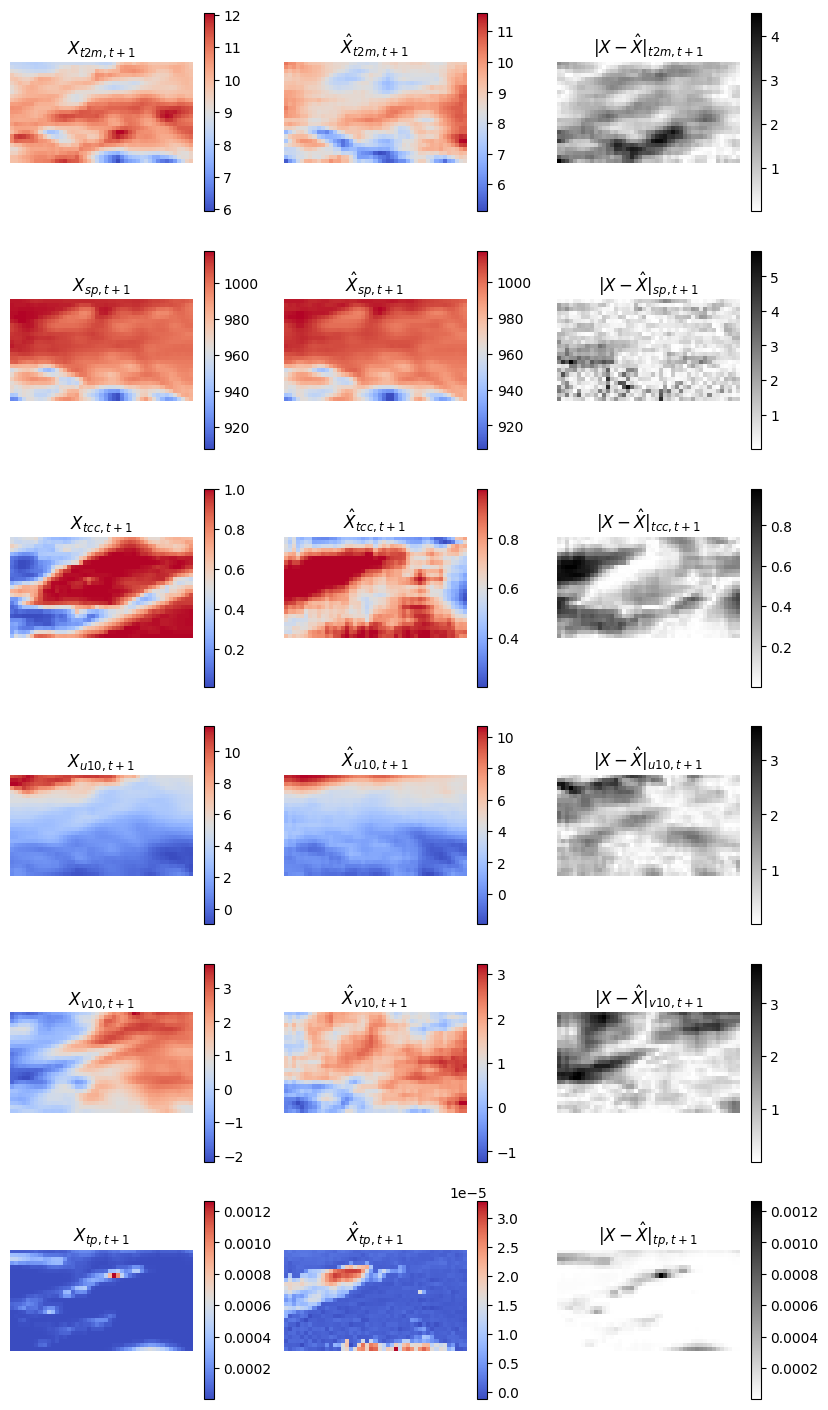

In [8]:
trainer.plot_predictions(data_type='train')